In [1]:
import warnings
import numpy as np

warnings.simplefilter("ignore", category=np.exceptions.VisibleDeprecationWarning)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from graph_cut import *

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
from sklearn.cluster import KMeans
import maxflow
from graph_cut import *

(576, 720, 3)
labels (576, 720)


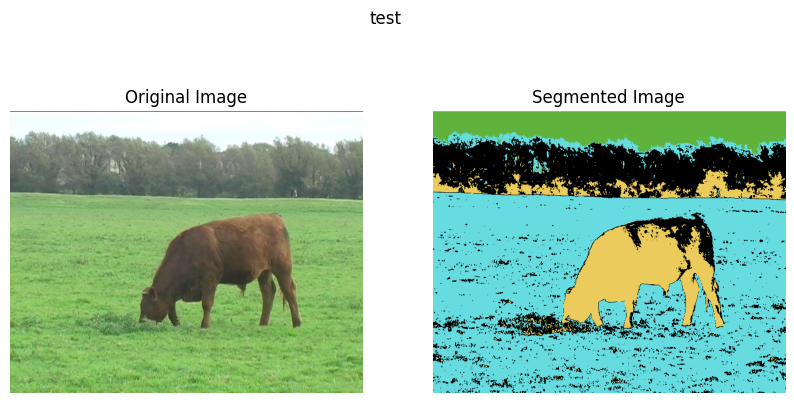

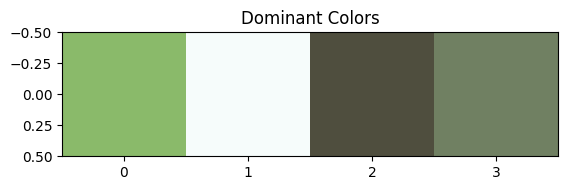

In [5]:
image_path = "images/cow.ppm"  # Replace with actual image path
K = 4
image = load_image(image_path)
print(image.shape)
labels = initialize_labels_bis(image, K=K, method="kmeans")
print("labels", labels.shape)
show_segmentation(image, labels, title="test")
show_dominant_colors(labels=labels, image=image, K=K)

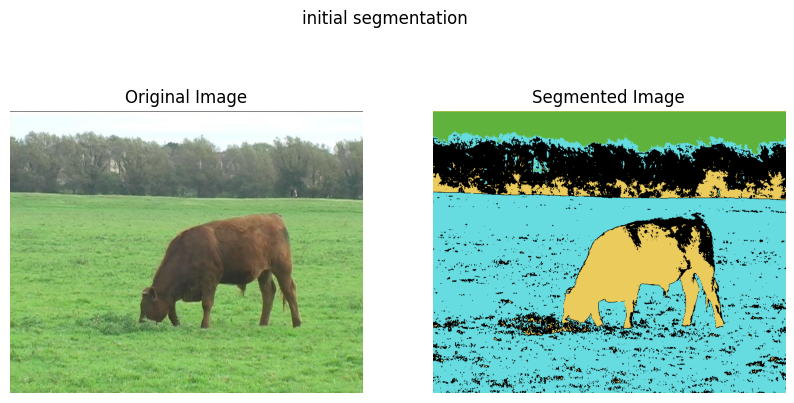

In [6]:
image_path = "images/cow.ppm"  # Replace with actual image path
K = 4
image = load_image(image_path)
labels = initialize_labels_bis(image, K=K, method="kmeans")
show_segmentation(image, labels, title="initial segmentation")

histograms = compute_histograms(image, labels, K=K, bins=16)
unary_term = compute_unary_term(image, labels, histograms, K, 16)
# dominants_colors=get_dominant_colors(labels=labels, image=image, K=K)
# unary_term = compute_unary_term_L2(image,dominants_colors)
pairwise_term = compute_pairwise_term(image, K=K, lambda_val=200)

In [7]:
unary_term[60, 50, :]

array([18.42068074, 18.42068074, 18.42068074,  3.86383638])

In [8]:
pairwise_term[0, 0]

array([[  0., 200., 200., 200.],
       [200.,   0., 200., 200.],
       [200., 200.,   0., 200.],
       [200., 200., 200.,   0.]])

In [9]:
# labels=np.argmin(unary_term, axis=2)
# print(labels.shape)
# from graph_cut.alpha_expansion import Alpha_expansion2
# a_exp=Alpha_expansion2(image=image,unary=unary_term,pairwise=pairwise_term,K=K,max_iterations=4)
# labels=a_exp.run(image)

## Step 2 : instead with 2 class


In [10]:
from graph_cut.recycle import *

In [11]:
# def unary_recycle(unary, label, K):
#     #! CHATGPT
#     """Constructs a new unary term for the recycle algorithm."""
#     W,H,k=unary.shape
#     unary_term = np.zeros((W,H,2))

#     for i in range(unary.shape[0]):
#         for j in range(unary.shape[1]):
#             partition = np.partition(unary[i, j, :], 1)  # Get two smallest values
#             min_unary = partition[1] if unary[i, j, label] == partition[0] else partition[0]
#             unary_term[i,j,0]=unary[i,j,label]
#             unary_term[i,j,1]=min_unary


#     return unary_term
unary_term_recycled = unary_recycle(unary_term, 0, K)
unary_term_recycled.shape

(576, 720, 2)

In [12]:
unary_term.shape

(576, 720, 4)

In [13]:
# def binary_recycle(pairwise_term,K):
#     # Construct the new binary term used for the recycle alogorithm for label lm
#     pairwise_term_recycled=np.zeros((pairwise_term.shape[0],pairwise_term.shape[1],2,2))
#     for i in range(pairwise_term.shape[0]):
#         for j in range(pairwise_term.shape[1]):
#             gamma=pairwise_term[i,j,0,1]
#             pairwise_term_recycled[i,j,0,1]=pairwise_term_recycled[i,j,1,0]=gamma

#     return pairwise_term_recycled
pairwise_term_recycled = binary_recycle(pairwise_term, K)

In [17]:
# class recycle_alpha_expansion2:
#     # to remove the self.assigned labels , just remove the if condition in the construct graph
#     def __init__(self,image,unary,pairwise,K,max_iterations):
#         self.l_energy=[]
#         self.unary=unary
#         self.pairwise=pairwise
#         self.K=K
#         self.h=image.shape[0]
#         self.w=image.shape[1]
#         self.max_iterations=max_iterations
#         self.epsilon=-1
#         self.assigned_labels=np.ones((self.h,self.w))*self.epsilon
#         self.cst=0 #! Cstant term in the energy
#         # labels = np.argmin(unary, axis=2)  # Initialize labels using unary term
#         # labels = initialize_labels_bis(image,method=method, K=K)

#     def construct_graph(self,alpha,labels,assigned_labels):
#         graph = maxflow.Graph[float]()
#         h=self.h
#         w=self.w
#         nodes = graph.add_nodes(h * w)

#         pairwise=self.pairwise
#         unary=self.unary

#         for i in range(h):
#             for j in range(w):
#         # Add unary terms
#                 pixel_index = i * w + j
#                 if assigned_labels[i,j]==self.epsilon:
#                     graph.add_tedge(nodes[pixel_index], unary[i, j,0], unary[i,j,1])  # Keep alpha pixels fixed


#         # Add pairwise terms
#                 if i < h-1:
#                     neighbor_index_down = pixel_index + w

#                     weight_down = pairwise[i, j,0,1] #?

#                     if assigned_labels[i,j] ==self.epsilon and assigned_labels[i+1,j]==self.epsilon:
#                         graph.add_edge(nodes[pixel_index], nodes[neighbor_index_down], weight_down, weight_down)

#                 if j < w-1:
#                     neighbor_index_right = pixel_index + 1
#                     weight_right = pairwise[i, j, 0,1]
#                     if assigned_labels[i,j] ==self.epsilon and assigned_labels[i,j+1]==self.epsilon:
#                         graph.add_edge(nodes[pixel_index], nodes[neighbor_index_right], weight_right, weight_right)
#         return graph,nodes


#     def run(self,image,init_assignments=None):
#         h, w, _ = image.shape
#         unary=self.unary.copy()
#         print("unary",unary.shape)
#         pairwise=self.pairwise
#         l_energy=self.l_energy
#         K=self.K
#         max_iterations=self.max_iterations
#         if init_assignments is not None:
#             labels = init_assignments
#         else:
#             labels = np.argmin(unary, axis=2)
#         # project to int
#         labels=labels.astype(np.int32)
#         show_segmentation(image, labels,title="initialization")
#         # energy=compute_energy(labels,unary,pairwise)
#         l_energy.append(energy)
#         assigned_labels=self.assigned_labels # Will be True iif the pixel is assigned to a label and will not move
#         # print("first energy",compute_energy(labels,unary,pairwise))
#         for alpha in range(K):
#             print("the alpha",alpha)
#             print("unary",unary.shape)
#             print("assinged labels",np.unique(assigned_labels))
#             unary_term_recycled=unary_recycle(unary, alpha, K)
#             pairwise_term_recycled=binary_recycle(pairwise,K)
#             self.unary=unary_term_recycled
#             self.pairwise=pairwise_term_recycled
#             # Construct graph
#             graph,nodes=self.construct_graph(alpha,labels,assigned_labels=assigned_labels)
#             print(len(nodes))
#             # Compute min-cut
#             graph.maxflow()

#             print(" IS MAXFLOW WORKING?")
#             # Update labels
#             nv_labels,assigned_labels=self.update_labels(graph,nodes, alpha,labels,assigned_labels=assigned_labels)
#             # nv_energy=compute_energy(nv_labels,unary,pairwise)
#             # print("computed energy",nv_energy,"it is inférieur à l'énergie actuel?",nv_energy<energy)
#             unary,pairwise=self.project(nv_labels,assigned_labels,unary,pairwise)
#             labels=nv_labels
#             # energy=nv_energy
#             l_energy.append(energy)


#             show_segmentation(image, labels, K,title=f"iteration {_} alpha {alpha}")
#             # return labels,assigned_labels

#         print("final segmentation",show_segmentation(image, labels, K))
#         return labels,assigned_labels,self.cst
#         # if _ % 5 == 0:
#         #     show_segmentation(image, labels, K)

#     def project(self,labels,assigned_labels,unary,pairwise):
#         # Project the function Using the initial code.
#         # Slide the pairwise term and update the corresponding pairwise term
#         for i in range(self.h-1):
#             for j in range(self.w-1):
#                 idx1=[]
#                 idx2=[]
#                 if i < self.h-1:
#                     idx1.append((i,j))
#                     idx2.append((i+1,j))
#                 if j < self.w-1:
#                     idx1.append((i,j))
#                     idx2.append((i,j+1))
#                 for l in range(len(idx1)):
#                     node=idx1[l]
#                     neighbor=idx2[l]
#                     # print("node",node,"neighbor",neighbor)

#                     if assigned_labels[node]==self.epsilon and assigned_labels[neighbor]!=self.epsilon:
#                         for k in range(self.K):

#                             unary[node[0],node[1],k]+=pairwise_term[node[0],node[1],k,labels[neighbor[0],neighbor[1]]]
#                     elif assigned_labels[node[0],node[1]]!=self.epsilon and assigned_labels[neighbor[0],neighbor[1]]==self.epsilon:
#                         for k in range(self.K):
#                             unary[neighbor[0],neighbor[1],k]+=pairwise_term[node[0],node[1],labels[node[0],node[1]],k]
#                     elif assigned_labels[node[0],node[1]]!=self.epsilon and assigned_labels[neighbor[0],neighbor[1]]!=self.epsilon:
#                         self.cst+=pairwise_term[node[0],node[1],labels[node[0],node[1]],labels[neighbor[0],neighbor[1]]]

#         # Update the pairwise term
#         for i in range(self.h):
#             for j in range(self.w):
#                 if assigned_labels[i,j]!=self.epsilon:
#                     self.cst+=unary_term[i,j,labels[i,j]]
#         return unary,pairwise


#     def update_labels(self,graph,nodes, alpha,labels,assigned_labels):
#         h,w=self.h,self.w
#         nv_labels=labels.copy()
#         for i in range(h):
#             for j in range(w):
#                 pixel_index = i * w + j
#                 if graph.get_segment(nodes[pixel_index]) == 1: #!
#                     # print("updated label",i,j,alpha)
#                     nv_labels[i, j] = alpha
#                     if assigned_labels[i,j]==self.epsilon:
#                         assigned_labels[i,j]=1
#                     else:
#                         print("we have already assigned this pixel to a label, is it normal?",assigned_labels[i,j],i,j)
#         return nv_labels,assigned_labels
from graph_cut.recycle import Recycle

recycling = Recycle(image=image, unary=unary_term, pairwise=pairwise_term, K=K)

---start Projection---


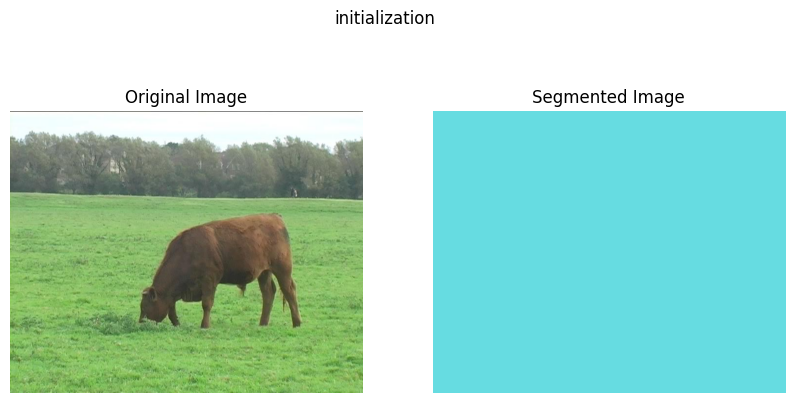

alpha 0


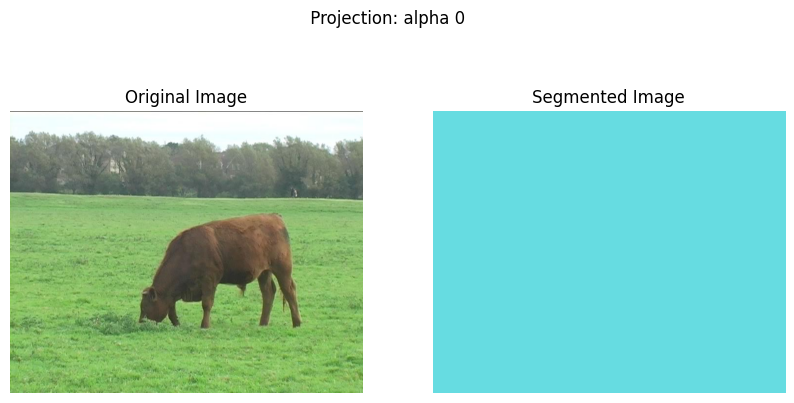

alpha 1


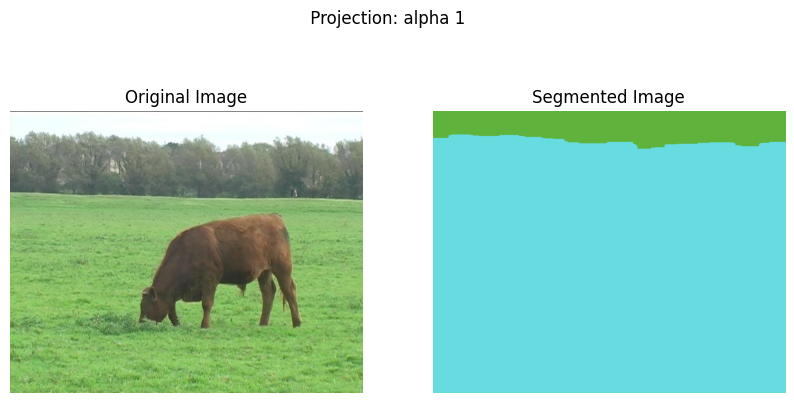

alpha 2


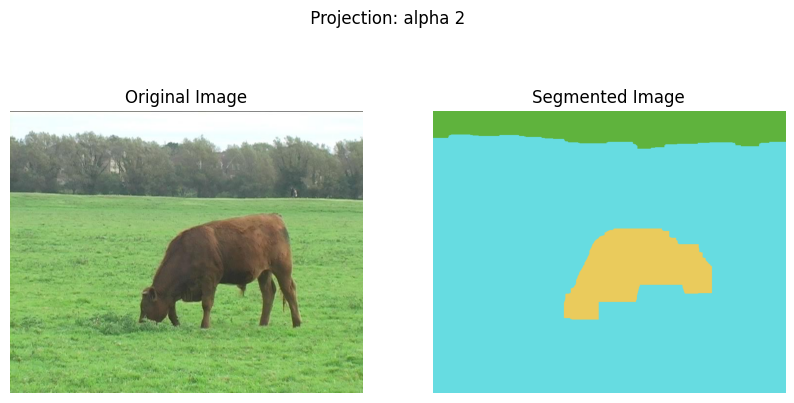

alpha 3


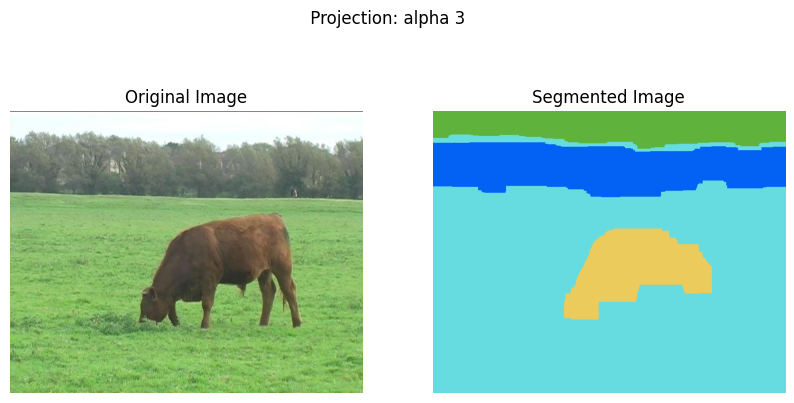

In [20]:
recycling = Recycle(image=image, unary=unary_term, pairwise=pairwise_term, K=K)

init_assigment = np.zeros((image.shape[0], image.shape[1])) * -1  #! No assignement
labels, assigned_labels, cst, unary, pairwise = recycling.run(
    image=image, init_assignments=init_assigment
)